# Predict Bike Rentals

On this project we'll try to predict how many kikes will be rented any given day.

We'll use a csv file with the data for bike rentals for a year on Washington DC. Hadi Fanaee-T at the University of Porto compiled this data. The file is available at [the University of California at Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)

We'll start by reading the the file and taking a look at it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


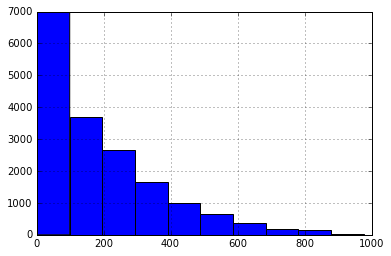

In [2]:
bike_rentals['cnt'].hist() #let's see the typical rental ammounts per day

In [21]:
bike_rentals['cnt'].mean()

189.46308763450142

In [3]:
#what columns correlate more to the cnt
bike_rentals.corr().loc[:,'cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [4]:
#We'll choose all the columns for features except:
#cnt, dteday, registered and casual because these last two 
#are derived from count so they can inject unwanted data 
#into our predictions

features = list(bike_rentals.columns.drop(['cnt','registered','casual','dteday']))

## Feature Engineering

Before we can start applying Machine Learning models let's work on some of the columns to help the model work better. 
Let's start by the hour column. The hours are related to each other but the model will treat each hour separately.

In [5]:
def assign_label(n):
    if (n>=6) and (n<12):
        return 1
    if (n>=12) and (n<18):
        return 2
    if (n>=18) and (n<24):
        return 3
    if (n>=0) and (n<12):
        return 4

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
    

In [6]:
bike_rentals['time_label'].head(10) 
#we used numeric labels because 
#some Machine Learning models need numeric featrues

0    4
1    4
2    4
3    4
4    4
5    4
6    1
7    1
8    1
9    1
Name: time_label, dtype: int64

## Splitting the dataset

We will split the dataset into two parts, a training and a test part. this is for training the model on the training set and test results on the other so we can calculate the accuracy. 
To know how effective our model is we will use a mae and mse.

In [7]:
train = bike_rentals.sample(frac=0.8,random_state=1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [8]:
test.shape

(3476, 18)

In [9]:
train.shape

(13903, 18)

## Applying models
We'll apply different machine learning models and later ensemble them in a random forrest for maximun accuracy

#### Let's start by Linear Regression
Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with cnt.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [11]:
lr = LinearRegression()

In [12]:
lr.fit(train[features],train['cnt'])
predictions = lr.predict(test[features])
lr_mae = metrics.mean_absolute_error(test['cnt'],predictions)
lr_mse = metrics.mean_squared_error(test['cnt'],predictions)
print(lr_mse,lr_mae)

19580.734550455003 104.63808594054555


We need to fit other models to compare the mse of this model, but we know that this model has an aproximate error of 98 units off the cnt

Now we're ready to apply the decision tree algorithm. We'll be able to compare its error with the error from linear regression, which will enable us to pick the right algorithm for this data set.

In [13]:
from sklearn.tree import DecisionTreeRegressor

In [14]:
#let's play with maximun depth minimun_sample_leaf
results = {}

for i in range(1,10):
    for v in range (1,10):
        dt = DecisionTreeRegressor(max_depth=i,min_samples_leaf=v)
        dt.fit(train[features],train['cnt'])
        predictions = dt.predict(test[features])
        dt_mse = metrics.mean_squared_error(test['cnt'],predictions)
        results[dt_mse] = (i,v)

results
        

{4005.6993036476792: (9, 9),
 4022.7268090329685: (9, 8),
 4033.127736125922: (9, 7),
 4046.5546676305544: (9, 4),
 4052.789787174608: (9, 5),
 4060.1681001070087: (9, 3),
 4064.3975266208327: (9, 6),
 4117.284940123262: (9, 2),
 4199.2811121233835: (9, 1),
 5137.559410116075: (8, 9),
 5157.813460577297: (8, 7),
 5158.952073780749: (8, 8),
 5164.78356926867: (8, 2),
 5167.279004471807: (8, 5),
 5167.543479748549: (8, 6),
 5168.441856703274: (8, 4),
 5168.579285801981: (8, 3),
 5240.415347183768: (8, 1),
 6902.622142612437: (7, 2),
 6904.1629977333005: (7, 1),
 6906.381298611644: (7, 3),
 6907.053901283486: (7, 4),
 6907.3034726027345: (7, 5),
 6909.781389443795: (7, 6),
 6911.750157980825: (7, 7),
 6912.282592868505: (7, 8),
 6913.526998946762: (7, 9),
 10457.57044522323: (6, 2),
 10458.312045857578: (6, 1),
 10465.438015126794: (6, 9),
 10465.53388547115: (6, 4),
 10465.534322827072: (6, 5),
 11668.267188969145: (5, 9),
 13695.523654101526: (4, 9),
 15499.548646817384: (3, 9),
 18537.

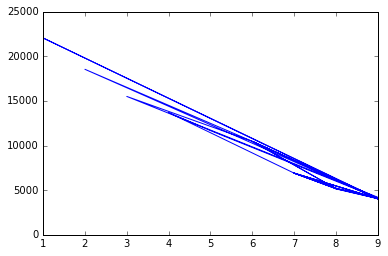

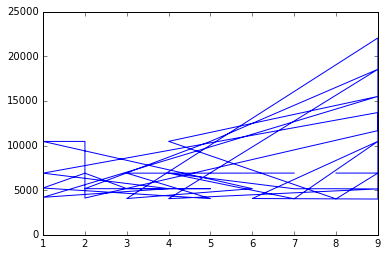

In [15]:
#we can see that for depth = 9 and min_split = 5 we got a minimun mse
#let's plot and see the results for visual
y = []
depths = []
min_samples = []
for key, val in results.items():
    y.append(key)
    depths.append(val[0])
    min_samples.append(val[1])
plt.plot(depths,y)
plt.show()
plt.plot(min_samples,y)
plt.show()
    

We can see that for all the iterations the min value was around max_depth = 9 and min_samples_leaf = 9. We'll use these for our tree

We can also see that we got a much higher accuracy with this model than with the Linear Regresion model. Our mse on the LR model was 17K, here it is 4K. Much better!!!

#### Let's now use a Random Forrest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor
#let's play with minimun_sample_leaf
results = {}

for i in range(1,10):
        rf = RandomForestRegressor(min_samples_leaf=i,random_state=1)
        rf.fit(train[features],train['cnt'])
        predictions = rf.predict(test[features])
        rf_mae = metrics.mean_absolute_error(test['cnt'],predictions)
        rf_mse = metrics.mean_squared_error(test['cnt'],predictions)
        results[i] = (rf_mse,rf_mae)

results
        

{1: (2122.3958170310707, 26.76915995397008),
 2: (2067.376584698912, 26.786403992456208),
 3: (2077.3392868237393, 26.970174513416705),
 4: (2151.5820489371335, 27.379494733798186),
 5: (2215.436989521778, 27.841951703393725),
 6: (2314.330509100319, 28.419285102159346),
 7: (2396.583764231162, 28.974380697279816),
 8: (2476.7247268186698, 29.266126354935142),
 9: (2544.0783211240387, 29.708904338365247)}

# Conclusion
We can see that the forrest did impresively better with 2 min_sample_leaf. 

We came down from 17K mse to 4K mse with tree to 2K mse with random forrest. This model is one of the best ML algoriths our there nowadays.

Now our algorithm predicts how many bikes will be rented on any given day with an aproximate 13% of accuracy. As a final note, we could probably improve this with some more tweaking. See if you can do it!